<a href="https://colab.research.google.com/github/tnwls6865/Creative_Masters/blob/main/week6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creative Masters

## TensorFlow를 활용한 Style Transfer 구현

### Style Transfer Module 불러오기

In [ ]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

In [ ]:
def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = tf.io.decode_image(
      tf.io.read_file(image_path),
      channels=3, dtype=tf.float32)[tf.newaxis, ...]
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

학습에 사용할 이미지도 가져오도록 하겠습니다.

In [ ]:
content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}
style_image_url = 'https://cdn.imweb.me/upload/S2017101359e025984d346/9c29fa134989d.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

TF Hub에서 사용할 모듈을 가져오도록 하겠습니다.

In [ ]:
# Load TF Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [ ]:
outputs = hub_module(content_image, style_image) 
stylized_image = outputs[0]

Style transfer 모듈을 실행하도록 하겠습니다.

In [ ]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

In [ ]:
# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

In [ ]:
!pip install torch==1.8.1 torchvision==0.9.1 torchaudio==0.8.1

### DeepDream 모듈 불러오기

딥드림은 신경망이 학습한 패턴을 시각화하는 실험입니다. 어린 아이가 구름을 보며 임의의 모양을 상상하는 것처럼, 딥드림은 주어진 이미지 내에 있는 패턴을 향상시키고 과잉해석합니다.

이 효과는 입력 이미지를 신경망을 통해 순전파 한 후, 특정 층의 활성화값에 대한 이미지의 그래디언트(gradient)를 계산함으로써 구현할 수 있습니다. 딥드림 알고리즘은 층의 활성화값을 최대화하도록 이미지를 수정하는데, 이는 신경망으로 하여금 특정 패턴을 과잉해석 하도록 합니다. 이로써 입력 이미지를 기반으로 하는 몽환적인 이미지를 만들어낼 수 있게 됩니다. 이 과정은 InceptionNet 모델과 영화 인셉션에서 이름을 따와 "Inceptionism"이라고 부릅니다.

그럼 이제 어떻게 하면 신경망으로 하여금 이미지에 있는 초현실적인 패턴을 향상시키고 “꿈”을 꾸도록 만들 수 있는지 알아보도록 하겠습니다.

In [ ]:
import tensorflow as tf
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

변환할 이미지를 가져오도록 하겠습니다.

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

In [ ]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

이제 특징을 추출한 모델을 준비하도록 하겠습니다.

사전 훈련된 이미지 분류 모델을 내려받습니다. 딥드림에서 원래 사용된 모델과 유사한 InceptionV3를 사용합니다. 다른 사전 학습된 모델을 사용해도 괜찮지만, 코드 구현 시 층의 이름을 수정해야 합니다.

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

딥드림은 활성화시킬 하나 혹은 그 이상의 층을 선택한 후 "손실"을 최대화하도록 이미지를 수정함으로써 선택한 층을 "excites"시키는 원리를 기반으로 합니다. 얼마나 복잡한 특성이 나타날지는 선택한 층에 따라 다르게 됩니다. 낮은 층을 선택한다면 획 또는 간단한 패턴이 향상되고, 깊은 층을 선택한다면 이미지 내의 복잡한 패턴이나 심지어 물체의 모습도 생성할 수 있습니다.

InceptionV3는 상당히 큰 모델입니다 (모델 구조의 그래프는 텐서플로 연구 저장소에서 확인할 수 있습니다). 모델의 많은 층들 중, 딥드림을 구현하기 위해 살펴보아야 할 곳은 합성곱층들이 연결된 부분입니다. InceptionV3에는 'mixed0'부터 'mixed10'까지 총 11개의 이러한 합성곱층이 있습니다. 이 중 어떤 층을 선택하느냐에 따라서 딥드림 이미지의 모습이 결정됩니다. 깊은 층은 눈이나 얼굴과 같은 고차원 특성(higher-level features)에 반응하는 반면, 낮은 층은 선분이나 모양, 질감과 같은 저차원 특성에 반응합니다. 임의의 층을 선택해 자유롭게 실험해보는 것도 가능합니다. 다만 깊은 층(인덱스가 높은 층)은 훈련을 위한 그래디언트 계산에 시간이 오래 걸릴 수 있습니다.

In [ ]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

손실은 선택한 층들의 활성화값의 총 합으로 계산됩니다. 층에 상관 없이 모든 활성화값이 동일하게 고려될 수 있도록 각 층의 손실을 정규화합니다. 일반적으로, 손실은 경사하강법으로 최소화하고자 하는 수치입니다. 하지만 딥드림에서는 예외적으로 이 손실을 경사상승법(gradient ascent)을 통해 최대화할 것입니다.

In [ ]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

선택한 층의 손실을 구했다면, 이제 남은 순서는 입력 이미지에 대한 그래디언트를 계산하여 원본 이미지에 추가하는 것입니다.

원본 이미지에 그래디언트를 더하는 것은 신경망이 보는 이미지 내의 패턴을 향상시키는 일에 해당합니다. 훈련이 진행될수록 신경망에서 선택한 층을 더욱더 활성화시키는 이미지를 생성할 수 있습니다.

In [ ]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [ ]:
deepdream = DeepDream(dream_model)

In [ ]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

In [ ]:
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)

지금 생성된 이미지도 상당히 인상적이지만, 위의 시도는 몇 가지 문제점들을 안고 있습니다:

    생성된 이미지에 노이즈(noise)가 많이 끼어있습니다.
    생성된 이미지의 해상도가 낮습니다.
    패턴들이 모두 균일한 입도(granularity)로 나타나고 있습니다.

이 문제들을 해결할 수 있는 한 가지 방법은 경사상승법의 스케일(scale)를 달리하여 여러 차례 적용하는 것입니다. 이는 작은 스케일에서 생성된 패턴들이 큰 스케일에서 생성된 패턴들에 녹아들어 더 많은 디테일을 형성할 수 있도록 해줍니다.

이 작업을 실행하기 위해서는 이전에 구현한 경사상승법을 사용한 후, 이미지의 크기(이를 옥타브라고 부릅니다)를 키우고 여러 옥타브에 대해 이 과정을 반복합니다.

In [ ]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

한 가지 고려할 사항은 이미지의 크기가 커질수록 그래디언트 계산에 소요되는 시간과 메모리가 늘어난다는 점입니다. 따라서 위에서 구현한 방식은 옥타브 수가 많거나 입력 이미지의 해상도가 높은 상황에는 적합하지 않습니다.

입력 이미지를 여러 타일로 나눠 각 타일에 대해 그래디언트를 계산하면 이 문제를 피할 수 있습니다.

각 타일별 그래디언트를 계산하기 전에 이미지를 랜덤하게 이동하면 타일 사이의 이음새가 나타나는 것을 방지할 수 있습니다.

이미지를 랜덤하게 이동시키는 작업부터 시작합니다:

In [ ]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

In [ ]:
shift, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

In [ ]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients

In [ ]:
get_tiled_gradients = TiledGradients(dream_model)

이 모든 것을 종합하면 확장 가능한 (scalabe) 옥타브 기반의 딥드림 구현이 완성됩니다.

In [ ]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))

  result = deprocess(img)
  return result

In [ ]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

## PyTorch를 활용한 Style Transfer 구현

### Neural Style Transfer (A Neural Algorithm of Artistic Style)

이 알고리즘은 Content 이미지, Style 이미지를 가져와서 Content 이미지의 Content와 Style 이미지의 예술적 Style을 닮도록 입력을 변환합니다.

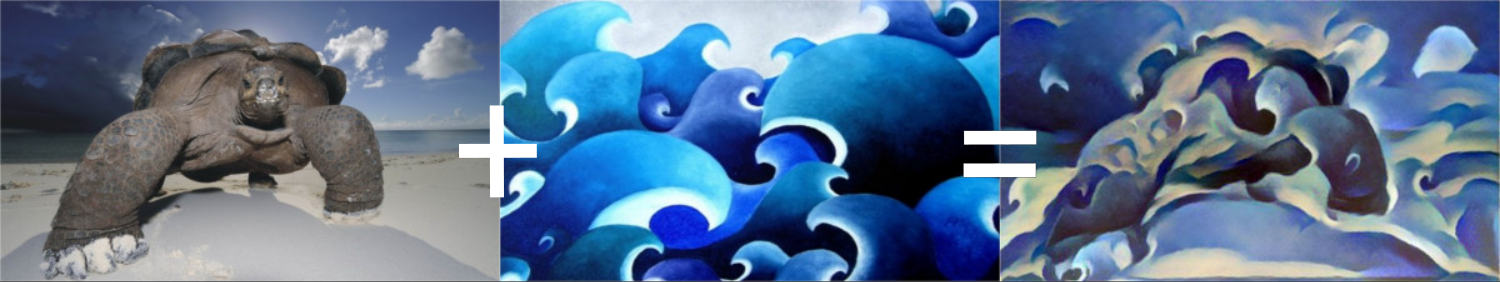

- 기본 원리

원리는 간단합니다. Content($D_c$)와 Style($D_s$​)에 대해 하나씩 두 개의 거리를 정의합니다. $D_c$ 는 두 이미지 간의 Content의 차이를 측정하고 $D_s$​ 는 두 이미지 간의 Style의 차이를 측정합니다. 그런 다음, 입력으로 사용되는 세 번째 이미지를 가져와서 Content 이미지로 Content 거리와 Style 이미지로 Style 거리를 최소화하도록 변환합니다. 이제 필요한 패키지를 가져와서 뉴럴 변환(neural transfer)을 시작할 수 있습니다.

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 이미지 불러오기

실습에 진행할 이미지를 불러오도록 하겠습니다.

In [ ]:
!wget -O picasso.jpg "https://tutorials.pytorch.kr/_static/img/neural-style/picasso.jpg"
!wget -O dancing.jpg "https://tutorials.pytorch.kr/_static/img/neural-style/dancing.jpg"

In [ ]:
# 원하는 출력 이미지의 크기
imsize = 512 if torch.cuda.is_available() else 128  # 만약 GPU가 없을 경우 작은 크기를 사용

loader = transforms.Compose([
    transforms.Resize(imsize),  # 가져온 이미지 크기 조정
    transforms.ToTensor()])  # 텐서로 변환


def image_loader(image_name):
    image = Image.open(image_name)
    # 네트워크의 입력 차원에 맞추기 위해 필요한 가짜 배치 차원
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("picasso.jpg")
content_img = image_loader("dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

이제 이미지를 PIL 형식으로 다시 변환하고 plt.imshow 를 사용해 이미지를 표시하는 함수를 만들겠습니다. Content와 Style 이미지를 표시하여 올바르게 가져왔는지 확인합니다.

In [ ]:
unloader = transforms.ToPILImage()  # PIL 이미지로 다시 변환

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # 텐서를 복제하여 변경하지 않음
    image = image.squeeze(0)      # 가짜 배치 차원 제거
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # plots가 업데이트 되도록 잠시 멈춤


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

#### Loss Function

- Content Loss

네트워크에 있는 하위 층의 활성화는 이미지 전체에 대해서 어느 한 부분에 한정되어 있는 정보를  담고 있습니다. 그에 비해 상위 층의 활성화는 전체적으로 추상적인 정보를 담게 됩니다. 상위층에서 보았을 때 생성된 이미지와 원본 이미지가 비슷하게 만들어질거라 예측할 수 있기 때문에 우리는 상위 층의 활성화로 계산을 할 것입니다. 이로서 우리는 원래  이미지의 전체적인 느낌을 보존할 수 있습니다. 

Content 거리를 계산하기 위해 사용되는 합성곱 계층 바로 뒤에 Content 손실 모듈을 추가합니다. 이렇게 하면 입력 이미지가 입력될 때마다 Content 손실이 원하는 레이어에서 계산되고 autograd 을 통해 모든 기울기가 계산됩니다. 이제 Content 손실 계층을 만들기 위해 Content 손실을 계산한 다음 계층의 입력을 반환하는 forward 메소드를 정의해야합니다. 계산된 손실은 모듈의 매개 변수로써 저장됩니다.

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # 기울기를 동적으로 계산하는데 사용되는 tree로부터 타깃 Content를 `분리(detach)` 합니다.
        # 이것은 변수가 아니라 명시된 값입니다.
        # 그렇지 않으면 criterion의 forward 메소드에서 오류가 발생합니다.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

- Style Loss

스타일 손실은 반대로, 컨브넷의 여러 층을 사용합니다. 여기서 활성화 출력의 gram matrix을 스타일 손실로 사용했습니다. 그람  행렬은 아래 그림과 같이 각 층의 특성 맵들을 내적 값이 성분이 되는데 내적을 함으로서 층의 특성 사이에 있는 상관관계를  표현한다고 이해할 수 있습니다.

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=배치 크기(=1)
    # b=특징 맵의 수
    # (c,d)=특징 맵의 차원 (N=c*d)

    features = input.view(a * b, c * d)  # F_XL을 \hat F_XL로 크기 조정

    G = torch.mm(features, features.t())  # gram product를 계산

    # 각 특징 맵이 갖는 값의 수로 나누어
    # gram 행렬의 값을 '정규화'
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

#### 모델 불러오기

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

추가적으로, VGG 네트워크는 mean=[0.485, 0.456, 0.406] 와 std=[0.229, 0.224, 0.225]로 각 채널이 정규화 된 이미지로 훈련됩니다. 이미지를 네트워크로 입력하기 전에 정규화하는데 사용합니다.

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# 입력 이미지를 정규화하는 모듈을 생성하여 쉽게 nn.Sequential에 넣을 수 있습니다.
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view 는 mean과 std을 확인해 [B x C x H x W] 형태의
        # 이미지 텐서를 직접적으로 작업할 수 있도록 [C x 1 x 1] 형태로 만듭니다.
        # B는 배치 크기입니다. C는 채널의 수입니다. H는 높이고 W는 너비입니다.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # img 정규화
        return (img - self.mean) / self.std

Sequential 모듈은 순서가 있는 하위 모듈의 리스트가 포함됩니다. 예를 들어, vgg19.features 은 올바른 순서로 정렬 된 시퀀스(Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…)가 포함되어 있습니다. Content 손실과 Style 손실 계층을 감지하는 합성곱 계층 바로 뒤에 추가해야합니다. 이렇게 하기 위해서는 Content 손실과 Style 손실 모듈이 올바르게 삽입된 새로운 Sequential 모듈을 만들어야 합니다.

In [ ]:
# Style / Content 손실 계산을 원하는 계층
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # 모듈 정규화
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # Content / Style 손실이 반복적으로 접근할 수 있도록 하기 위해
    content_losses = []
    style_losses = []

    # cnn이 nn.Sequential이라고 가정하고,
    # 순차적으로 활성화되어야 하는 모듈에 새로운 nn.Sequential을 만듭니다.
    model = nn.Sequential(normalization)

    i = 0  # conv를 볼 때마다 증가
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # in-place 버전은 아래에 삽입한 Content 손실과 Style 손실와 잘 어울리지 않습니다.
            # 그래서 여기서는 out-of-place로 대체합니다.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # Content 손실 추가
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # Style 손실 추가
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 이제 마지막 Content 및 Style 손실 뒤에 계층을 잘라냅니다.
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [ ]:
input_img = content_img.clone()
# 만약 화이트 노이즈(white noise)을 사용하려면 아래 주석을 제거하세요
# input_img = torch.randn(content_img.data.size(), device=device)

# 그림에 원본 입력 이미지를 추가합니다.
plt.figure()
imshow(input_img, title='Input Image')

#### 경사하강법

Adam 알고리즘을 사용하여 경사 하강법을 수행합니다. 네트워크 훈련과 다르게 Content / Style 손실을 최소화하기 위해 입력 이미지를 훈련하려고 합니다. 파이토치 adam optimizer optim.Adam 를 만들고 최적화 할 텐서로 이미지를 전달합니다.

In [ ]:
def get_input_optimizer(input_img):
    # 입력이 기울기가 필요한 매개 변수임을 표시하는 줄
    optimizer = optim.Adam([input_img])
    return optimizer

마지막으로 뉴럴 변환(neural transfer)을 수행하는 함수를 정의해야 합니다. 네트워크의 각 반복 동안, 업데이트된 입력이 주어지고 새로운 손실을 계산합니다. 각 손실 모듈(Loss module)의 backward 메소드를 실행하여 기울기를 동적으로 계산합니다. optimizer는 모듈을 재평가하고 손실을 반환하는 “closure” 함수가 필요합니다.

여전히 해결해야 할 마지막 제약이 있습니다. 네트워크가 이미지에 대해 0 ~ 1 텐서 범위를 초과하는 값으로 최적화하려 할 수 있습니다. 네트워크가 실행될 때마다 입력값을 0에서 1사이로 수정하여 문제를 해결할 수 있습니다.

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # 모델의 매개변수를 제외한 입력을 최적화해야 하므로
    # 이에 맞춰서 requires_grad 값을 갱신합니다.
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # 업데이트 된 입력 이미지의 값을 수정
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

### Feature Inversion (Understanding Deep Image Representations by Inverting Them [A Mahendran et al. CVPR 2015])

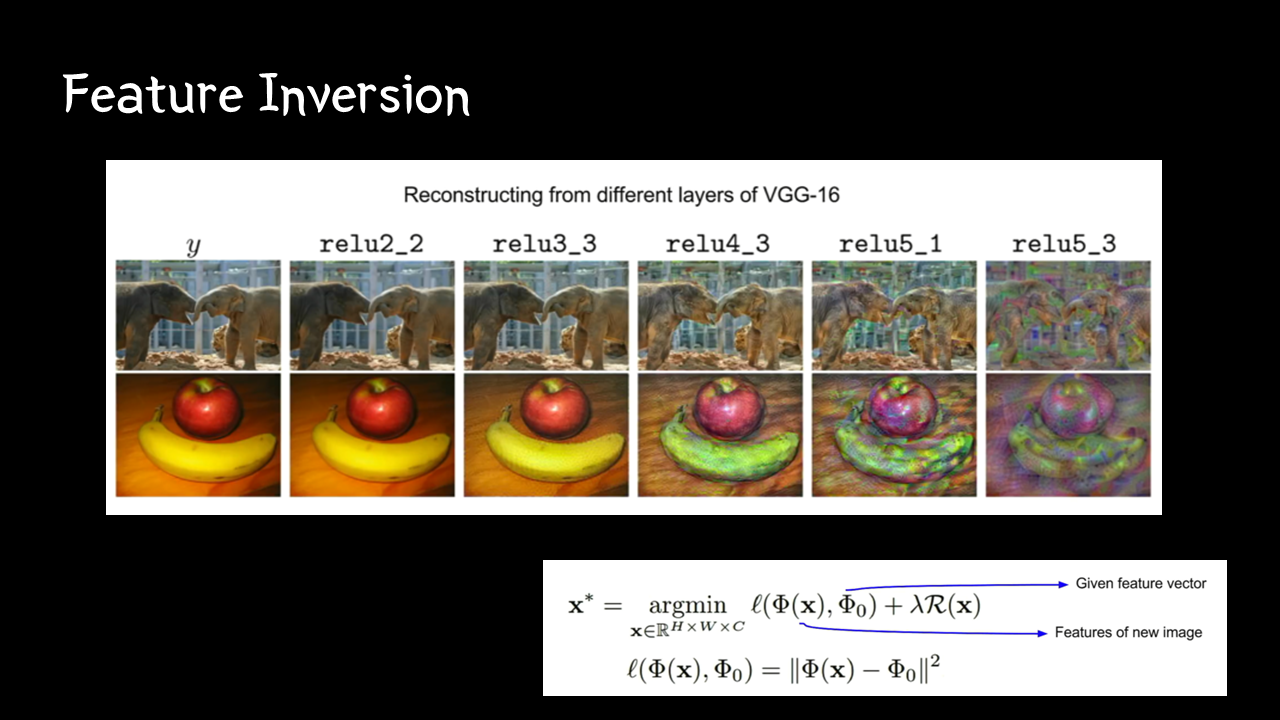

Inversion: 반전
Feature inversion은 Feature들을 Inversion(반전)시켜서 다시 이미지를 원래 이미지로 복구시키는 것을 의미합니다.

기존까지는 Classification, Generation 등의 태스크를 잘 진행하기 위해서 주요한 Feature들을 잘 찾는것에 집중했다면, 이번 Style transfer 작업을 위해서는 이미지를 재구성 하는 것에 초점을 두도록 하겠습니다.

논문: https://arxiv.org/pdf/1412.0035.pdf

In [ ]:
!pip install --quiet git+https://github.com/greentfrapp/lucent.git

!wget -qnc https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png

In [ ]:
from PIL import Image
import numpy as np
import scipy.ndimage as nd
import torch

from google.colab import files

from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import inceptionv1
from lucent.misc.io import show

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = inceptionv1(pretrained=True)
_ = model.to(device).eval()

#### Code 구현

입력 이미지와 대상 이미지의 특징 표현 간의 코사인 유사도를 최대화하기 위해 내적 objective function를 구현합니다.

In [ ]:
@objectives.wrap_objective()
def dot_compare(layer, batch=1, cossim_pow=0):
  def inner(T):
    dot = (T(layer)[batch] * T(layer)[0]).sum()
    mag = torch.sqrt(torch.sum(T(layer)[0]**2))
    cossim = dot/(1e-6 + mag)
    return -dot * cossim ** cossim_pow
  return inner

In [ ]:
def feature_inversion(img, layer=None, n_steps=512, cossim_pow=0.0):
  # Convert image to torch.tensor and scale image
  img = torch.tensor(np.transpose(img, [2, 0, 1])).to(device)
  upsample = torch.nn.Upsample(224)
  img = upsample(img)
  
  obj = objectives.Objective.sum([
    1.0 * dot_compare(layer, cossim_pow=cossim_pow),
    objectives.blur_input_each_step(),
  ])

  # Initialize parameterized input and stack with target image
  # to be accessed in the objective function
  params, image_f = param.image(224)
  def stacked_param_f():
    return params, lambda: torch.stack([image_f()[0], img])

  transforms = [
    transform.pad(8, mode='constant', constant_value=.5),
    transform.jitter(8),
    transform.random_scale([0.9, 0.95, 1.05, 1.1] + [1]*4),
    transform.random_rotate(list(range(-5, 5)) + [0]*5),
    transform.jitter(2),
  ]

  _ = render.render_vis(model, obj, stacked_param_f, transforms=transforms, thresholds=(n_steps,), show_image=False, progress=False)

  show(_[0][0])

In [ ]:
!wget -O dog_cat.png -qnc https://p.kindpng.com/picc/s/214-2140447_transparent-dog-and-cat-png-dog-cat-and.png

In [ ]:
Image.open("dog_cat.png")

In [ ]:
img = np.array(Image.open("dog_cat.png").resize((224,224)), np.float32)

layers = ['conv2d%d' % i for i in range(0, 3)] + \
         ['mixed3a', 'mixed3b', 'mixed4a',
          'mixed4b', 'mixed4c', 'mixed4d',
          'mixed4e', 'mixed5a', 'mixed5b']

In [ ]:
for layer in layers:
  print(layer)
  feature_inversion(img, layer=layer)
  print()

#### Varying Cossine Similarity

해당 코드는 코사인 유사도와 관련한 값들을 조정해볼 수도 있습니다. 해당 term의 값을 높이면 출력이 activation을 더욱 많이 반영하게 됩니다.

In [ ]:
for cossim in [0.0, 0.5, 1.0, 2.0]:
  print(cossim)
  feature_inversion(img, layer='mixed4d', cossim_pow=cossim)
  print()

#### Custom Image

이제 한번 각자의 이미지를 불러와서 사용해보도록 하겠습니다.

In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
  img = np.array(Image.open(fn).resize((224,224)), np.float32)
  show(img/255)
  feature_inversion(img, layer='mixed4d')

### DeepDream (Inceptionism: Going Deeper into Neural Networks)

In [ ]:
!pip install torch-dreams  --upgrade

#### Code 구현

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torch_dreams import Dreamer
import torchvision.models as models
plt.rcParams['figure.figsize'] = 5,5

In [ ]:
model = models.inception_v3(pretrained=True)
dreamy_boi = Dreamer(model, device = 'cuda', quiet =  False)

In [ ]:
image_param = dreamy_boi.render(
    layers = [model.Mixed_5b],
)
plt.imshow(image_param)
plt.show()

In [ ]:
image_param = dreamy_boi.render(
    layers = [model.Mixed_5b],
    width = 512,
    height = 256,
    iters = 150,
    lr = 9e-3,
    rotate_degrees = 15,
    scale_max = 1.2,
    scale_min =  0.5,
    translate_x = 0.2,
    translate_y = 0.2,
    custom_func = None,
    weight_decay = 1e-2,
    grad_clip = 1,
)

In [ ]:
plt.imshow(image_param)
plt.show()

다음 단계는 단일 채널을 선택적으로 최적화하는 데 사용할 수 있는 custom_func를 정의하는 것입니다. 우리는 더 간단한 기능을 만들 수 있었지만 이것은 많은 채널에서 최적화를 실행할 때 유용할 것입니다.

In [ ]:
"""
feel free to use more layers for experiments 
"""
layers_to_use = [model.Mixed_6b.branch1x1.conv]

def make_custom_func(layer_number = 0, channel_number= 0): 
    def custom_func(layer_outputs):
        loss = layer_outputs[layer_number][channel_number].mean()
        return -loss
    return custom_func

이제 첫 번째 레이어의 7번째 채널을 최적화하기 위해 사용자 지정 손실을 다음과 같이 정의합니다.

In [ ]:
my_custom_func = make_custom_func(layer_number= 0, channel_number = 119)

In [ ]:
image_param = dreamy_boi.render(
    layers = layers_to_use,
    custom_func = my_custom_func,
    iters = 200
)
plt.imshow(image_param)
plt.show()

#### Custom Image

이제 주어진 데이터가 아닌 각자의 데이터를 활용해보도록 하겠습니다.

In [ ]:
!wget -O animals.jpg "https://eli5.readthedocs.io/en/latest/_images/keras-image-classifiers_5_11.png"

In [ ]:
from torch_dreams.custom_image_param import CustomImageParam

my_custom_func = make_custom_func(layer_number = 0, channel_number = 19)
layers_to_use = [model.Mixed_6b.branch1x1.conv]

In [ ]:
param = CustomImageParam(image = 'animals.jpg', device= 'cuda')

image_param = dreamy_boi.render(
    image_parameter= param,
    layers = layers_to_use,
    lr = 2e-4,
    # weight_decay= 1e-1,
    iters = 20,  ## mild
    custom_func = my_custom_func
)

In [ ]:
%matplotlib inline
import cv2
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize=(10,5))
ax.flat[0].imshow(cv2.cvtColor(cv2.imread('animals.jpg'), cv2.COLOR_BGR2RGB))
ax.flat[1].imshow(image_param)

GoogleNet (Inception v1)로 모델을 변경해보겠습니다.

In [ ]:
from torch_dreams.custom_image_param import CustomImageParam

param = CustomImageParam('animals.jpg', device = 'cuda')
image_tensor = param.to_nchw_tensor()  ## could be any other NCHW tensor

In [ ]:
model = models.googlenet(pretrained = True)
dreamy_boi = Dreamer(model = model, quiet= False, device= 'cuda')

image_param = dreamy_boi.caricature(
    input_tensor = image_tensor, 
    layers = [model.inception4c],   ## feel free to append more layers for more interesting caricatures 
    power= 1.2,
)

In [ ]:
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize=(10,10))
ax.flat[0].imshow(param)
ax.flat[1].imshow(image_param)

### AdaIN (Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization [X Huang et al. ICCV 2017])

In [ ]:
# 필요한 PyTorch 라이브러리 불러오기
import torch
import torch.nn as nn

from torchvision import transforms
from torchvision.utils import save_image

from PIL import Image
from IPython.display import Image as display_image

논문의 핵심 아이디어인 Instance Normalization을 위한 평균과 표준편차 계산 function과 Adaptive Instance Normalization function을 구현합니다.

In [ ]:
def calc_mean_std(feat, eps=1e-5):
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def adaptive_instance_normalization(content_feat, style_feat):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)

    # 평균(mean)과 표준편차(std)를 이용하여 정규화 수행
    normalized_feat = (content_feat - content_mean.expand(size)) / content_std.expand(size)
    # 정규화 이후에 style feature의 statistics를 가지도록 설정
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)

인코더와 디코더를 정의해놓습니다.

In [ ]:
# 인코더(Encoder) 정의
vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(), # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(), # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(), # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(), # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(), # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(), # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU() # relu5-4
)

# 디코더(Decoder) 정의
decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

사전학습된 모델을 불러오겠습니다.

In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1 -O decoder.pth
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXzxBZI0seBFuxucQjlShBEBtM7X5-Lmj-ceqZ5Fu96alA?download=1 -O vgg_normalised.pth

In [ ]:
decoder.eval()
vgg.eval()

vgg_path = './vgg_normalised.pth'
decoder_path = './decoder.pth'

decoder.load_state_dict(torch.load(decoder_path))
vgg.load_state_dict(torch.load(vgg_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
decoder.to(device)

vgg = nn.Sequential(*list(vgg.children())[:31]) # ReLU4_1까지만 사용

In [ ]:
class Net(nn.Module):
    def __init__(self, encoder, decoder):
        super(Net, self).__init__()
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(*enc_layers[:4]) # input -> relu1_1
        self.enc_2 = nn.Sequential(*enc_layers[4:11]) # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*enc_layers[11:18]) # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*enc_layers[18:31]) # relu3_1 -> relu4_1
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

        # fix the encoder
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    # extract relu1_1, relu2_1, relu3_1, relu4_1 from input image (중간 결과를 기록)
    def encode_with_intermediate(self, input):
        results = [input]
        for i in range(4):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]

    # extract relu4_1 from input image (최종 결과만 기록)
    def encode(self, input):
        for i in range(4):
            input = getattr(self, 'enc_{:d}'.format(i + 1))(input)
        return input

    # 콘텐츠 손실(feature 값 자체가 유사해지도록)
    def calc_content_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        return self.mse_loss(input, target)

    # 스타일 손실(feature의 statistics가 유사해지도록)
    def calc_style_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        input_mean, input_std = calc_mean_std(input)
        target_mean, target_std = calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + self.mse_loss(input_std, target_std)

    def forward(self, content, style, alpha=1.0):
        # 콘텐츠와 스타일 중 어떤 것에 더 많은 가중치를 둘지 설정 가능
        assert 0 <= alpha <= 1 # 0에 가까울수록 콘텐츠를 많이 살림
        style_feats = self.encode_with_intermediate(style)
        content_feat = self.encode(content)
        t = adain(content_feat, style_feats[-1])
        t = alpha * t + (1 - alpha) * content_feat

        g_t = self.decoder(t) # 결과 이미지
        g_t_feats = self.encode_with_intermediate(g_t)

        # 콘텐츠 손실과 스타일 손실을 줄이기 위해 두 개의 손실 값 반환
        loss_c = self.calc_content_loss(g_t_feats[-1], t)
        loss_s = self.calc_style_loss(g_t_feats[0], style_feats[0])
        for i in range(1, 4):
            loss_s += self.calc_style_loss(g_t_feats[i], style_feats[i])
        return loss_c, loss_s

실습에 사용할 이미지를 불러오도록 하겠습니다.

In [ ]:
!wget -O content_img_1.jpg "https://raw.githubusercontent.com/ndb796/Deep-Learning-Paper-Review-and-Practice/master/code_practices/images/content_img_1.jpg"
!wget -O style_img_1.jpg "https://raw.githubusercontent.com/ndb796/Deep-Learning-Paper-Review-and-Practice/master/code_practices/images/style_img_1.jpg"

최종적인 Style Transfer 함수를 작성하겠습니다.

In [ ]:
def style_transfer(vgg, decoder, content, style, alpha=1.0):
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)

In [ ]:
def test_transform(size=512):
    transform_list = []
    if size != 0:
        transform_list.append(transforms.Resize(size))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform

content_tf = test_transform()
style_tf = test_transform()

In [ ]:
content_path = 'content_img_1.jpg'
style_path = 'style_img_1.jpg'

content = content_tf(Image.open(str(content_path)))
style = style_tf(Image.open(str(style_path)))

style = style.to(device).unsqueeze(0)
content = content.to(device).unsqueeze(0)
with torch.no_grad():
    output = style_transfer(vgg, decoder, content, style, alpha=1.0)
output = output.cpu()

save_image(output, 'output.png')

In [ ]:
# 결과 이미지 출력
display_image('./output.png')

#### Video Style Transfer Example

In [ ]:
!git clone https://github.com/westgarthb/style-transfer-video-processor.git -q
%cd /content/style-transfer-video-processor
!pip -q install -r requirements.txt 2> /dev/null
from google.colab import files
uploaded_file = None

In [ ]:
class Config:
    ROOT_PATH = '.'
    # defines the maximum height dimension in pixels. Used for down-sampling the video frames
    FRAME_HEIGHT = 368
    CLEAR_INPUT_FRAME_CACHE = True
    # defines the rate at which you want to capture frames from the input video
    INPUT_FPS = 20
    INPUT_VIDEO_NAME = 'input_vid.mov'
    if uploaded_file:
      INPUT_VIDEO_NAME = list(uploaded_file.keys())[0]
    INPUT_VIDEO_PATH = f'{ROOT_PATH}/{INPUT_VIDEO_NAME}'
    INPUT_FRAME_DIRECTORY = f'{ROOT_PATH}/input_frames'
    INPUT_FRAME_FILE = '{:0>4d}_frame.png'
    INPUT_FRAME_PATH = f'{INPUT_FRAME_DIRECTORY}/{INPUT_FRAME_FILE}'

    STYLE_REF_DIRECTORY = f'{ROOT_PATH}/style_ref'
    # defines the reference style image transition sequence. Values correspond to indices in STYLE_REF_DIRECTORY
    # add None in the sequence to NOT apply style transfer for part of the video (ie. [None, 0, 1, 2])  
    STYLE_SEQUENCE = [0, 1, 2]

    OUTPUT_FPS = 20
    OUTPUT_VIDEO_NAME = 'output_video.mp4'
    OUTPUT_VIDEO_PATH = f'{ROOT_PATH}/{OUTPUT_VIDEO_NAME}'
    OUTPUT_FRAME_DIRECTORY = f'{ROOT_PATH}/output_frames'
    OUTPUT_FRAME_FILE = '{:0>4d}_frame.png'
    OUTPUT_FRAME_PATH = f'{OUTPUT_FRAME_DIRECTORY}/{OUTPUT_FRAME_FILE}'

    GHOST_FRAME_TRANSPARENCY = 0.1
    PRESERVE_COLORS = False

    TENSORFLOW_CACHE_DIRECTORY = f'{ROOT_PATH}/tensorflow_cache'
    TENSORFLOW_HUB_HANDLE = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'


In [ ]:
from style_frames import StyleFrame
StyleFrame(Config).run()

In [ ]:
files.download('output_video.mp4')

### FuseDream: Training-Free Text-to-Image Generation with Improved CLIP+GAN Space Optimization

In [ ]:
!git clone https://github.com/gnobitab/FuseDream.git
!pip install ftfy regex tqdm numpy scipy h5py lpips==0.1.4
!pip install git+https://github.com/openai/CLIP.git
!pip install gdown
!gdown 'https://drive.google.com/uc?id=17ymX6rhsgHDZw_g5XgAFW4xLSDocARCM'
!gdown 'https://drive.google.com/uc?id=1sOZ9og9kJLsqMNhaDnPJgzVsBZQ1sjZ5'

In [ ]:
!ls
!cp biggan-256.pth FuseDream/BigGAN_utils/weights/
!cp biggan-512.pth FuseDream/BigGAN_utils/weights/
%cd FuseDream

In [ ]:
import torch
from tqdm import tqdm
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import torchvision
import BigGAN_utils.utils as utils
import clip
import torch.nn.functional as F
from DiffAugment_pytorch import DiffAugment
import numpy as np
from fusedream_utils import FuseDreamBaseGenerator, get_G, save_image

In [ ]:
#@title Parameters
SENTENCE = "A photo of a blue dog." #@param {type:"string"}
INIT_ITERS =  1000#@param {type:"number"}
OPT_ITERS = 1000#@param {type:"number"}
NUM_BASIS = 5#@param {type:"number"}
MODEL = "biggan-256" #@param ["biggan-256","biggan-512"]
SEED = 0#@param {type:"number"}

import sys
sys.argv = [''] ### workaround to deal with the argparse in Jupyter

In [ ]:
### Generation: Click the 'run' button and the final generated image will be shown after the end of the algorithm
utils.seed_rng(SEED) 

sentence = SENTENCE

print('Generating:', sentence)
if MODEL == "biggan-256":
    G, config = get_G(256) 
elif MODEL == "biggan-512":
    G, config = get_G(512) 
else:
    raise Exception('Model not supported')
generator = FuseDreamBaseGenerator(G, config, 10) 
z_cllt, y_cllt = generator.generate_basis(sentence, init_iters=INIT_ITERS, num_basis=NUM_BASIS)

z_cllt_save = torch.cat(z_cllt).cpu().numpy()
y_cllt_save = torch.cat(y_cllt).cpu().numpy()
img, z, y = generator.optimize_clip_score(z_cllt, y_cllt, sentence, latent_noise=False, augment=True, opt_iters=OPT_ITERS, optimize_y=True)
### Set latent_noise = True yields slightly higher AugCLIP score, but slightly lower image quality. We set it to False for dogs.
score = generator.measureAugCLIP(z, y, sentence, augment=True, num_samples=20)
print('AugCLIP score:', score)
import os
if not os.path.exists('./samples'):
    os.mkdir('./samples')
save_image(img, 'samples/fusedream_%s_seed_%d_score_%.4f.png'%(sentence, SEED, score))

from IPython import display
display.display(display.Image('samples/fusedream_%s_seed_%d_score_%.4f.png'%(sentence, SEED, score)))